In [5]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PersonaClassifier import process_embeddings
from PersonaClassifier import MLP
from sklearn.preprocessing import StandardScaler


# 1. Read Test Data

In [2]:
test_data = pd.read_csv('data/pandora_processed_test.csv')
test_data = test_data.loc[:, ~test_data.columns.str.contains('^Unnamed:')]
cols = ['cOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON']
# true_data = test_data[['STATUS']+cols]
df = test_data.drop_duplicates(subset='STATUS')
dff = df[['STATUS']+cols]

In [3]:
contextual_embeddings = process_embeddings(df, 'roberta-base') 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
all_cols = df.columns
remove_cols = ['STATUS', 'cEXT','cNEU', 'cAGR', 'cCON', 'cOPN']
emb_cols = ['bert_embeddings', 'berttweet_embeddings', 'xlnet_embeddings', 'roberta_embeddings']
stat_cols = list (set(all_cols) - set(remove_cols) - set(emb_cols))
scaler = StandardScaler() 
stat_features = df[stat_cols]
stat_features_scaled = scaler.fit_transform(stat_features)
X = np.concatenate([stat_features_scaled, contextual_embeddings], axis=1)

# 2. Load the model and generate prediction for each label

In [8]:
for col in cols:
    y = np.array(df[[col]]) 
    model_filepath = f"checkpoint/2024-11-22_14-23-35/MLP_{col}.pth"
    model = MLP(input_size=X.shape[1], hidden_size=128, output_size=1)
    model.load_state_dict(torch.load(model_filepath))
    print(f"Model loaded from {model_filepath}")
    model.eval()
    X_test_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():  
        outputs = model(X_test_tensor)
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()
    new_col = col.split('c')[1]
    preds_np = preds.numpy()
    dff[new_col] = preds.int()
    accuracy = accuracy_score(y, preds_np)
    precision = precision_score(y, preds_np)
    recall = recall_score(y, preds_np)
    f1 = f1_score(y, preds_np)
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Model loaded from checkpoint/2024-11-22_14-23-35/MLP_cOPN.pth
Accuracy: 0.5489, Precision: 0.6531, Recall: 0.4817, F1 Score: 0.5545
Model loaded from checkpoint/2024-11-22_14-23-35/MLP_cEXT.pth
Accuracy: 0.6020, Precision: 0.5587, Recall: 0.3994, F1 Score: 0.4658
Model loaded from checkpoint/2024-11-22_14-23-35/MLP_cNEU.pth
Accuracy: 0.5671, Precision: 0.5807, Recall: 0.3147, F1 Score: 0.4082
Model loaded from checkpoint/2024-11-22_14-23-35/MLP_cAGR.pth
Accuracy: 0.6010, Precision: 0.5885, Recall: 0.3106, F1 Score: 0.4066
Model loaded from checkpoint/2024-11-22_14-23-35/MLP_cCON.pth
Accuracy: 0.6685, Precision: 0.5808, Recall: 0.2774, F1 Score: 0.3755


/tmp/ipykernel_3640627/687654174.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[new_col] = preds.int()
/tmp/ipykernel_3640627/687654174.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[new_col] = preds.int()
/tmp/ipykernel_3640627/687654174.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [10]:
dff.head(4)

,STATUS,cOPN,cEXT,cNEU,cAGR,cCON,OPN,EXT,NEU,AGR,CON
0,I want in on this tournament. I would challeng...,1,1,1,1,1,1,1,1,1,1
1,The population of this subreddit is fucking ri...,0,1,1,1,1,1,1,1,1,0
2,Can I ask what that entails? How much time doe...,1,0,1,0,1,0,0,0,0,0
3,"We have a thing called a ""bingo"". Right now yo...",1,1,1,1,1,1,1,0,1,1


# 3. Read LLMs prediction 

In [11]:
gpt_df = pd.read_csv('/data/jmharja/projects/PersonaClassifier/data/LLMs_Labeled_Personality_PandoraData.csv')
gpt_df = gpt_df.loc[:, ~gpt_df.columns.str.contains('^Unnamed:')]

gpt_df = gpt_df.drop_duplicates(subset='STATUS')
columns = ['Openness','Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
cs = ['gOPN', 'gCON', 'gEXT', 'gAGR', 'gNEU']
gpt_means = {}
i=0
for col in columns:
    mean_value = gpt_df[col].mean()
    gpt_means[f'{col}'] = mean_value
    c = cs[i]
    i =i+1
    gpt_df[c] = gpt_df[col] > mean_value 
gpt_df[cs] = gpt_df[cs].replace({True: 1, False: 0})  
gpt_df = gpt_df[['STATUS']+cs]

In [12]:
all_data = pd.merge(dff, gpt_df , on='STATUS', how='inner')  # Options for 'how': 'inner', 'outer', 'left', 'right'

In [14]:
all_data.head(5)

,STATUS,cOPN,cEXT,cNEU,cAGR,cCON,OPN,EXT,NEU,AGR,CON,gOPN,gCON,gEXT,gAGR,gNEU
0,I want in on this tournament. I would challeng...,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1
1,The population of this subreddit is fucking ri...,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1
2,Can I ask what that entails? How much time doe...,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
3,"We have a thing called a ""bingo"". Right now yo...",1,1,1,1,1,1,1,0,1,1,1,1,0,1,1
4,That sounds awesome haha. I'm going to guess ...,1,1,0,0,0,1,1,0,0,0,0,1,1,1,0


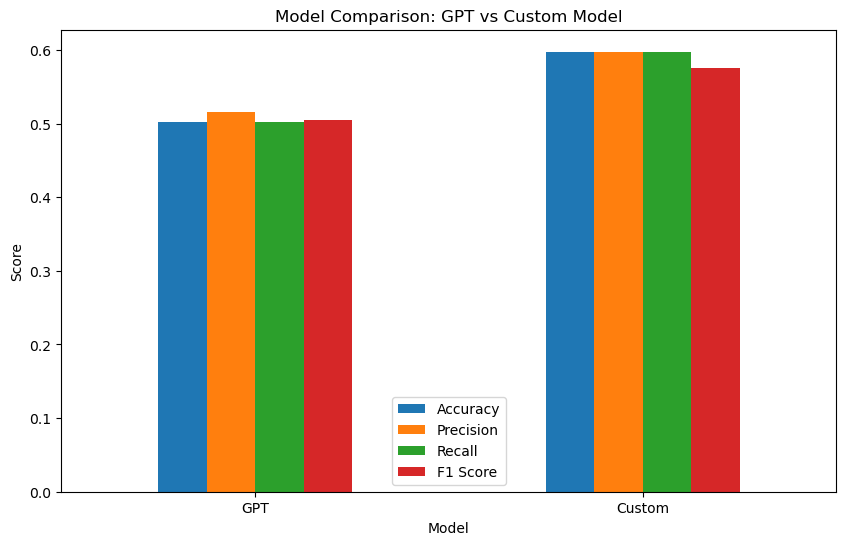

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the dataframe `df`
# True columns: ['cOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON']
# GPT columns: ['gOPN', 'gCON', 'gEXT', 'gAGR', 'gNEU']
# Custom model columns: ['OPN', 'CON', 'EXT', 'AGR', 'NEU']

# Initialize dictionaries to store metrics for each model
metrics_gpt = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
metrics_custom = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Calculate metrics for GPT and Custom model predictions
for true_col, gpt_col, custom_col in zip(
    ['cOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON'],
    ['gOPN', 'gEXT', 'gNEU', 'gAGR', 'gCON'],
    ['OPN', 'EXT', 'NEU', 'AGR', 'CON']
):
    # Get true and predicted values
    y_true = all_data[true_col]
    y_pred_gpt = all_data[gpt_col]
    y_pred_custom = all_data[custom_col]
    
    # Calculate metrics for GPT model
    metrics_gpt['accuracy'].append(accuracy_score(y_true, y_pred_gpt))
    metrics_gpt['precision'].append(precision_score(y_true, y_pred_gpt, average='weighted'))
    metrics_gpt['recall'].append(recall_score(y_true, y_pred_gpt, average='weighted'))
    metrics_gpt['f1'].append(f1_score(y_true, y_pred_gpt, average='weighted'))

    # Calculate metrics for Custom model
    metrics_custom['accuracy'].append(accuracy_score(y_true, y_pred_custom))
    metrics_custom['precision'].append(precision_score(y_true, y_pred_custom, average='weighted'))
    metrics_custom['recall'].append(recall_score(y_true, y_pred_custom, average='weighted'))
    metrics_custom['f1'].append(f1_score(y_true, y_pred_custom, average='weighted'))

# Create a DataFrame to summarize the metrics
metrics_df = pd.DataFrame({
    'Model': ['GPT', 'Custom'],
    'Accuracy': [sum(metrics_gpt['accuracy']) / 5, sum(metrics_custom['accuracy']) / 5],
    'Precision': [sum(metrics_gpt['precision']) / 5, sum(metrics_custom['precision']) / 5],
    'Recall': [sum(metrics_gpt['recall']) / 5, sum(metrics_custom['recall']) / 5],
    'F1 Score': [sum(metrics_gpt['f1']) / 5, sum(metrics_custom['f1']) / 5]
})

# Plot the results
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison: GPT vs Custom Model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


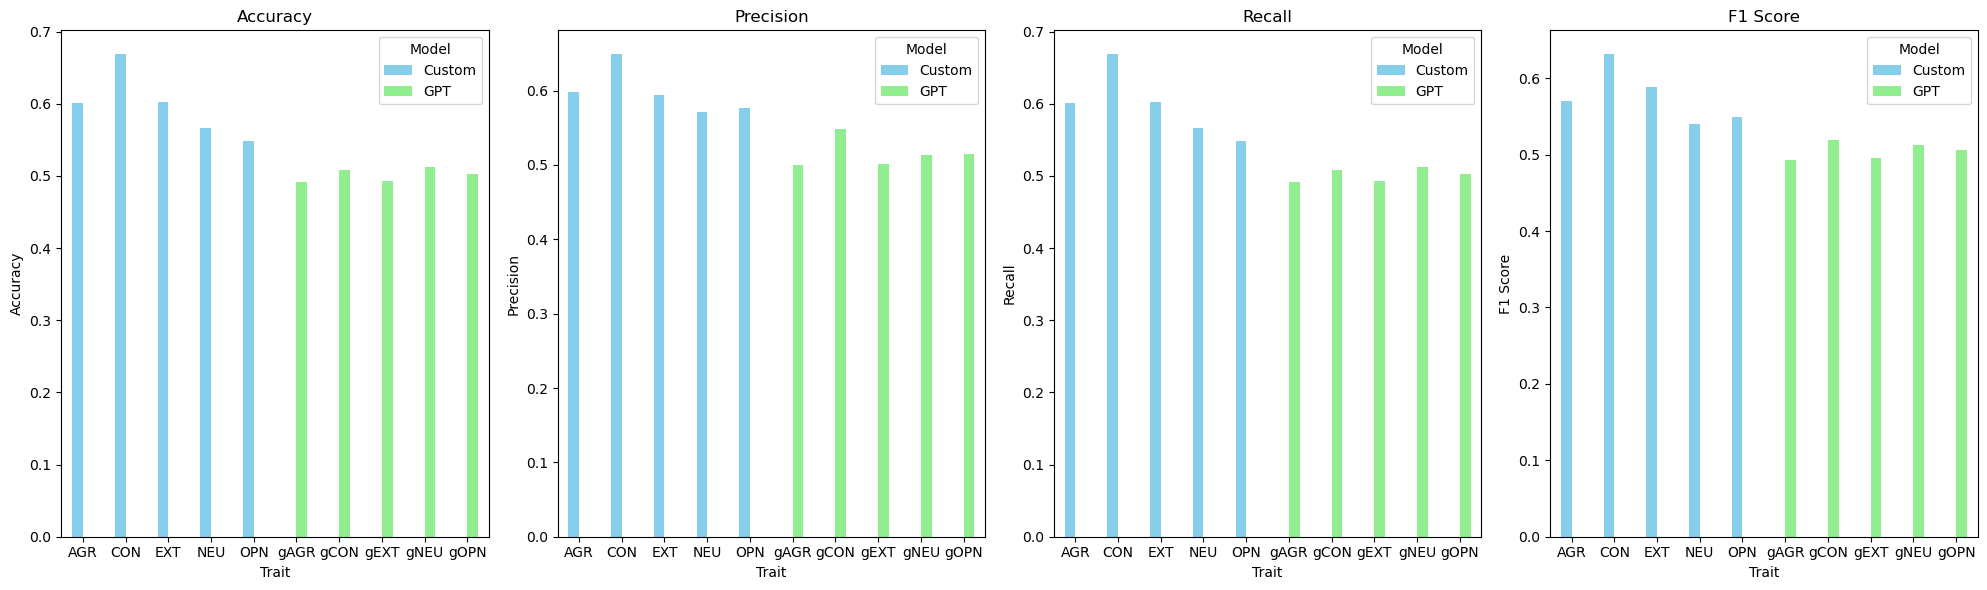

In [21]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming you have the dataframe `df`
# True columns: ['cOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON']
# GPT columns: ['gOPN', 'gCON', 'gEXT', 'gAGR', 'gNEU']
# Custom model columns: ['OPN', 'CON', 'EXT', 'AGR', 'NEU']

# Initialize a list to store metrics for each trait
metrics = []

# Calculate metrics for each trait (OPN, EXT, NEU, AGR, CON)
for true_col, gpt_col, custom_col in zip(
    ['cOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON'],
    ['gOPN', 'gEXT', 'gNEU', 'gAGR', 'gCON'],
    ['OPN', 'EXT', 'NEU', 'AGR', 'CON']
):
    # Get true and predicted values
    y_true = all_data[true_col]
    y_pred_gpt = all_data[gpt_col]
    y_pred_custom = all_data[custom_col]
    
    # Calculate metrics for GPT model
    metrics_gpt = {
        'Trait': gpt_col,
        'Model': 'GPT',
        'Accuracy': accuracy_score(y_true, y_pred_gpt),
        'Precision': precision_score(y_true, y_pred_gpt, average='weighted'),
        'Recall': recall_score(y_true, y_pred_gpt, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred_gpt, average='weighted')
    }
    
    # Calculate metrics for Custom model
    metrics_custom = {
        'Trait': custom_col,
        'Model': 'Custom',
        'Accuracy': accuracy_score(y_true, y_pred_custom),
        'Precision': precision_score(y_true, y_pred_custom, average='weighted'),
        'Recall': recall_score(y_true, y_pred_custom, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred_custom, average='weighted')
    }
    
    # Append the metrics for both models
    metrics.append(metrics_gpt)
    metrics.append(metrics_custom)

# Convert the metrics list to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot the comparison for each trait
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Iterate over each metric (Accuracy, Precision, Recall, F1 Score)
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    trait_metrics = metrics_df.pivot(index='Trait', columns='Model', values=metric)
    trait_metrics.plot(kind='bar', ax=ax, title=metric, ylabel=metric, xlabel='Trait', rot=0, color=['skyblue', 'lightgreen'])
    ax.set_xticklabels(trait_metrics.index)

plt.tight_layout()
plt.show()


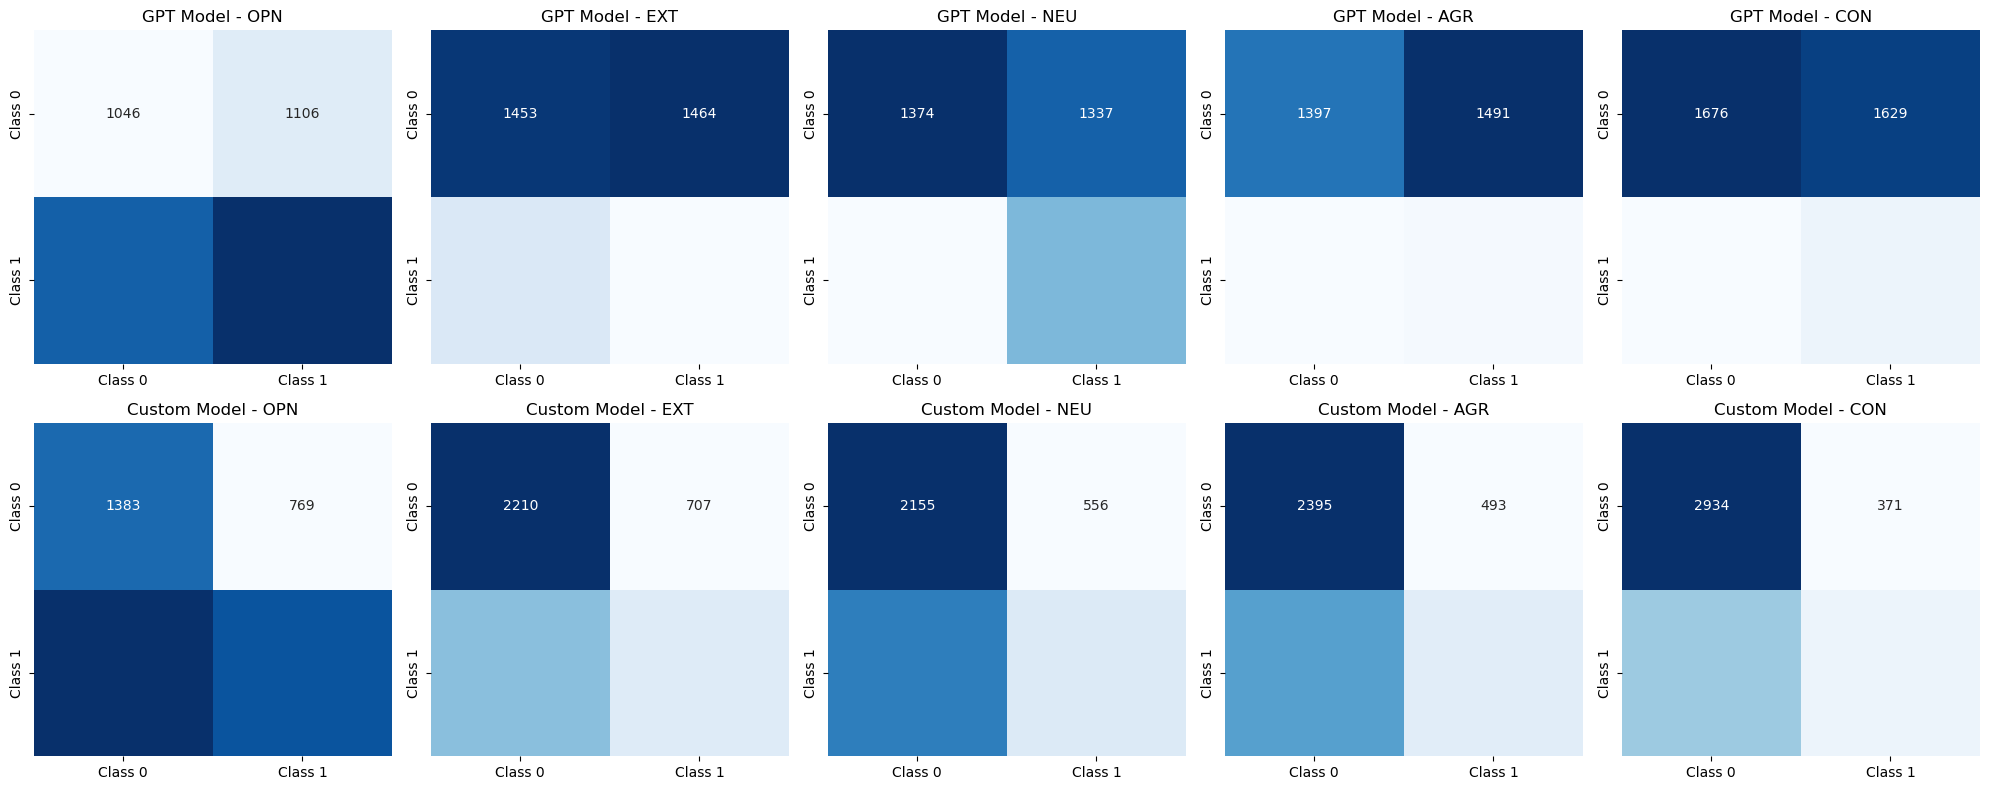

In [20]:
conf_matrix_gpt = []
conf_matrix_custom = []
for true_col, gpt_col, custom_col in zip(
    ['cOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON'],
    ['gOPN', 'gEXT', 'gNEU', 'gAGR', 'gCON'],
    ['OPN', 'EXT', 'NEU', 'AGR', 'CON']
):
    # Get true and predicted values
    y_true = all_data[true_col]
    y_pred_gpt = all_data[gpt_col]
    y_pred_custom = all_data[custom_col]
    
    # Compute confusion matrix for GPT model
    cm_gpt = confusion_matrix(y_true, y_pred_gpt)
    conf_matrix_gpt.append(cm_gpt)

    # Compute confusion matrix for Custom model
    cm_custom = confusion_matrix(y_true, y_pred_custom)
    conf_matrix_custom.append(cm_custom)

# Plot confusion matrices for GPT and Custom model
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot confusion matrices for GPT model
for i, cm in enumerate(conf_matrix_gpt):
    ax = axes[0, i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, 
                xticklabels=[f"Class {i}" for i in range(cm.shape[1])],
                yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
    ax.set_title(f'GPT Model - {["OPN", "EXT", "NEU", "AGR", "CON"][i]}')

# Plot confusion matrices for Custom model
for i, cm in enumerate(conf_matrix_custom):
    ax = axes[1, i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, 
                xticklabels=[f"Class {i}" for i in range(cm.shape[1])],
                yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
    ax.set_title(f'Custom Model - {["OPN", "EXT", "NEU", "AGR", "CON"][i]}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()